![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Importación de librerías
%matplotlib inline
import random
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.io as pio

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor

pio.renderers.default = "svg"

In [3]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
metrics_models = []

def evaluate_model(y, y_pred, name_model):
    rmse = np.sqrt(np.mean((y_pred - y) ** 2))
    mae = np.mean(np.abs(y_pred - y))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    
    return {
        'Nombre Modelo': name_model,
        'RMSE': round(rmse, 3),
        'MAE': round(mae, 3),
        'MAPE': round(mape, 3)
    }

In [7]:
class DecisionTreeRegressorManual:
    def __init__(self, min_gain=0.001, max_depth=None, num_pct=10):
        self.min_gain = min_gain
        self.max_depth = max_depth
        self.num_pct = num_pct
        self.final_tree_ = None


    # Definición de la función que calcula el gini index
    def _gini(self, y):
        return 0 if y.shape[0] == 0 else 1 - (y.mean()**2 + (1 - y.mean())**2)

    # Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
    def _gini_impurity(self, X_col, y, split):
        filter_l = X_col < split
        y_l = y.loc[filter_l]
        y_r = y.loc[~filter_l]
        
        n_l = y_l.shape[0]
        n_r = y_r.shape[0]
        
        gini_y = self._gini(y)
        gini_l = self._gini(y_l)
        gini_r = self._gini(y_r)
        
        gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
        return gini_impurity_

    # Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
    def _best_split(self, X, y):
        features = range(X.shape[1])
        best_split = [0, 0, 0]  # j, split, gain
        
        # Para todas las varibles 
        for j in features:
            splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (self.num_pct+1)).tolist())
            splits = np.unique(splits)[1:]
            
            # Para cada partición
            for split in splits:
                gain = self._gini_impurity(X.iloc[:, j], y, split)
                            
                if gain > best_split[2]:
                    best_split = [j, split, gain]
        
        return best_split

    # Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
    def _tree_grow(self, X, y, level=0):
        # Si solo es una observación
        if X.shape[0] == 1:
            tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=self.selevel, split=-1, n_samples=1, gain=0)
            return tree
        
        # Calcular la mejor división
        j, split, gain = self._best_split(X, y)
        
        # Guardar el árbol y estimar la predicción
        y_pred = int(y.mean() >= 0.5) 
        y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
        
        tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
        
        # Revisar el criterio de parada 
        if gain < self.min_gain:
            return tree
        if self.max_depth is not None:
            if level >= self.max_depth:
                return tree
        
        # Continuar creando la partición
        filter_l = X.iloc[:, j] < split
        X_l, y_l = X.loc[filter_l], y.loc[filter_l]
        X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
        tree['split'] = [j, split]
        
        # Siguiente iteración para cada partición
        tree['sl'] = self._tree_grow(X_l, y_l, level + 1)
        tree['sr'] = self._tree_grow(X_r, y_r, level + 1)
        
        return tree
    
    def fit(self, X, y):
        self.final_tree_ = self._tree_grow(X, y)

    # Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
    def _tree_predict(self, X, tree, proba=False):
        predicted = np.ones(X.shape[0])

        # Revisar si es el nodo final
        if tree['split'] == -1:
            if not proba:
                predicted = predicted * tree['y_pred']
            else:
                predicted = predicted * tree['y_prob']
        else:
            j, split = tree['split']
            filter_l = (X.iloc[:, j] < split)
            X_l = X.loc[filter_l]
            X_r = X.loc[~filter_l]

            if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
                predicted[~filter_l] = self._tree_predict(X_r, tree['sr'], proba)
            elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
                predicted[filter_l] = self._tree_predict(X_l, tree['sl'], proba)
            else:
                predicted[filter_l] = self._tree_predict(X_l, tree['sl'], proba)
                predicted[~filter_l] = self._tree_predict(X_r, tree['sr'], proba)

        return predicted
    
    def predict(self, X, proba=False):
        return self._tree_predict(X, self.final_tree_, proba)


In [8]:
# Celda 1
model_dtr = DecisionTreeRegressorManual(min_gain=0.001, max_depth=6, num_pct=3)  
model_dtr.fit(X_train, y_train)

y_pred = model_dtr.predict(X_test, proba=True)
metrics_m = evaluate_model(y_test, y_pred, 'Árbol de decisión manual')
metrics_models.append(metrics_m)
print(metrics_m)

{'Nombre Modelo': 'Árbol de decisión manual', 'RMSE': 1664.789, 'MAE': 1218.031, 'MAPE': 8.682}


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [9]:
# Celda 2
class BaggingRegressorManual:
    def __init__(self, estimator, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_ = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X.iloc[indices], y.iloc[indices]

    def fit(self, X, y):
        random.seed(self.random_state)

        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            self.estimator.fit(X_sample, y_sample)
            self.estimators_.append(self.estimator)

    def predict(self, X):
        X = X.values
        predictions = np.zeros((X.shape[0], self.n_estimators))

        for i, estimator in enumerate(self.estimators_):
            predictions[:, i] = estimator.predict(X)

        return np.mean(predictions, axis=1)

In [10]:
features_count = X.shape[1]
model_dtr =  DecisionTreeRegressor(max_features=int(np.log(features_count)))
bagreg = BaggingRegressorManual(model_dtr, n_estimators=10, random_state=1)
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)

metrics_m = evaluate_model(y_test, y_pred, 'Bagging manual')
metrics_models.append(metrics_m)
print(metrics_m)

{'Nombre Modelo': 'Bagging manual', 'RMSE': 2210.68, 'MAE': 1624.483, 'MAPE': 11.767}


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [11]:
# Celda 3
features_count = X.shape[1]
model_dtr = DecisionTreeRegressor(max_features=int(np.log(features_count)))
bagreg = BaggingRegressor(model_dtr, n_estimators=10, bootstrap=True, oob_score=True, random_state=1)
bagreg.fit(X_train, y_train)

y_pred = bagreg.predict(X_test)
metrics_m = evaluate_model(y_test, y_pred, 'Bagging')
metrics_models.append(metrics_m)
print(metrics_m)

{'Nombre Modelo': 'Bagging', 'RMSE': 1824.292, 'MAE': 1361.482, 'MAPE': 9.869}


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [12]:
# Celda 4
model_rf = RandomForestRegressor(n_estimators=10, max_features=int(np.log(features_count)), random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
metrics_m = evaluate_model(y_test, y_pred, 'Random forest')
metrics_models.append(metrics_m)
print(metrics_m)

{'Nombre Modelo': 'Random forest', 'RMSE': 1819.56, 'MAE': 1358.028, 'MAPE': 9.867}


In [13]:
pd.DataFrame({'feature':X.columns, 'importance':model_rf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
1,Mileage,0.473487
0,Year,0.413996
3,M_Camry4dr,0.057410
7,M_CamrySE,0.015667
8,M_CamryXLE,0.014552
2,M_Camry,0.011398
6,M_CamryLE,0.006733
4,M_CamryBase,0.004620
5,M_CamryL,0.002137


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [31]:
# Funciones necesarias
def plot_mape(ranges, mapes, xtitle = 'n_estimators'):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=(np.array(ranges)), y=mapes, mode='lines', name='MAPE'))
    fig.update_layout(xaxis_title=xtitle, yaxis_title='MAPE')
    fig.layout.width = 1000
    pio.show(fig)

def comparate_model_param(param, values, options_rf = {}):
    mapes = []

    for val in values:
        options_rf[param] = val;
        model_rf = RandomForestRegressor(**options_rf, random_state=1, n_jobs=-1)
        model_rf.fit(X_train, y_train)
        y_pred = model_rf.predict(X_test)
        
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        mapes.append(mape)

    display(pd.DataFrame({param: values, 'MAPE': mapes}).sort_values(by='MAPE').head(10))
    plot_mape(values, mapes, param)

,max_depth,MAPE
7,8,8.372469
6,7,8.383881
8,9,8.402061
9,10,8.468432
5,6,8.478258
10,11,8.564168
11,12,8.687782
4,5,8.725340
12,13,8.792940
13,14,8.903609


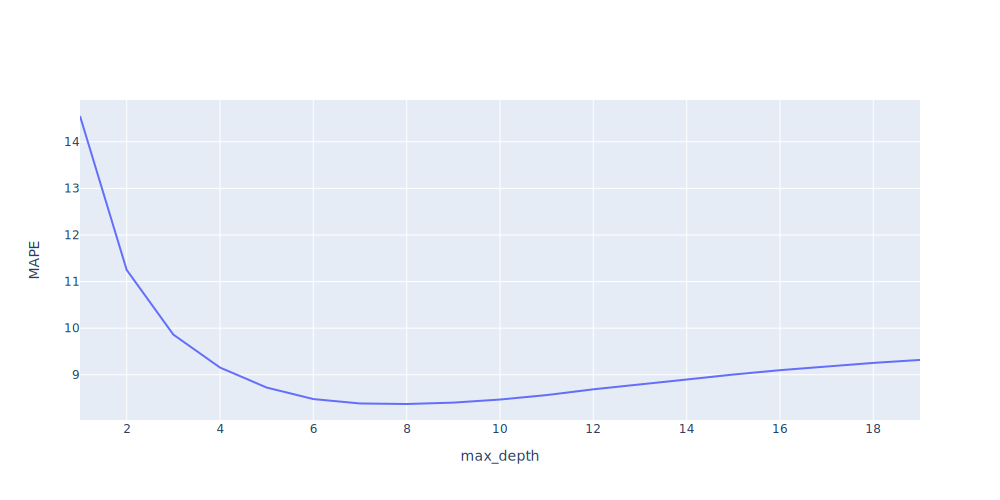

In [32]:
# Celda 5
comparate_model_param('max_depth', range(1, 20, 1))

> Se selecciona ```max_depth = 8``` ya que es donde se tiene un menor valor para **MAPE** con **8.37**. 

,max_features,MAPE
4,5,8.309425
5,6,8.319070
3,4,8.322219
6,7,8.339280
7,8,8.349985
2,3,8.356910
8,9,8.372469
1,2,8.391634
0,1,8.473430


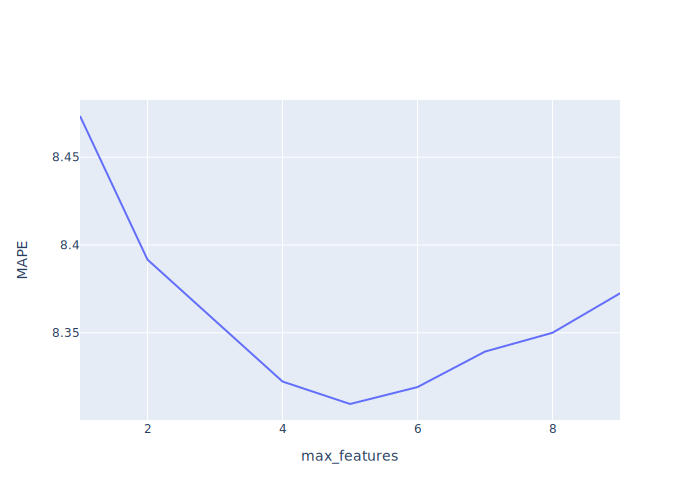

In [16]:
# Evaluar el mejor valor para el parámetro max_features
comparate_model_param('max_features', range(1, len(X.columns)+1), {'max_depth': 8})

> Para un ```max_depth = 8``` el mejor valor para ```max_features``` es ``5`` con un **MAPE** con **8.309**. 

,n_estimators,MAPE
7,400,8.300622
6,350,8.301885
5,300,8.303365
8,450,8.304708
4,250,8.306156
10,550,8.306345
3,200,8.306506
9,500,8.306707
1,100,8.309425
2,150,8.313997


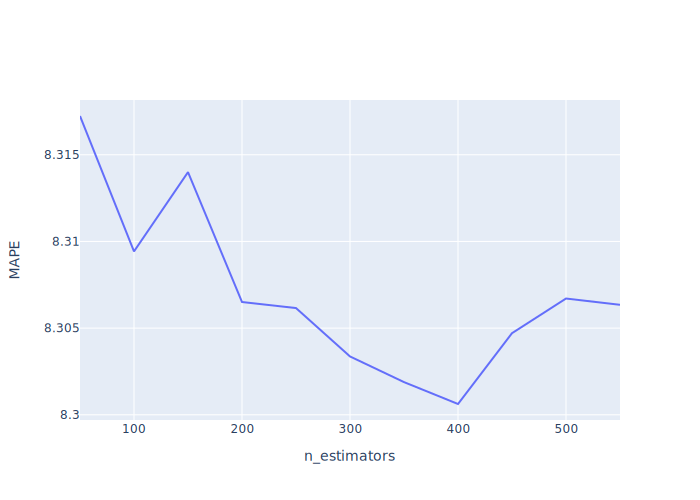

In [17]:
# Evaluar el mejor valor para el parámetro n_estimators
comparate_model_param('n_estimators', range(50, 600, 50), {'max_depth': 8, 'max_features': 5})

> Despues de analizar la gráfica los mejores estimadores son ```max_features=5, n_estimators=400, random_state=1```

In [18]:
model_rf = RandomForestRegressor(max_depth=8,  max_features=5, n_estimators=400, random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
metrics_m = evaluate_model(y_test, y_pred, 'Random forest optimizado')
metrics_models.append(metrics_m)
print(metrics_m)

{'Nombre Modelo': 'Random forest optimizado', 'RMSE': 1553.011, 'MAE': 1138.713, 'MAPE': 8.301}


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [19]:
# Celda 6
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
metrics_m = evaluate_model(y_test, y_pred, 'XGBoost')
metrics_models.append(metrics_m)
print(metrics_m)

{'Nombre Modelo': 'XGBoost', 'RMSE': 1621.42, 'MAE': 1186.634, 'MAPE': 8.649}


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [20]:
# Celda 7
# Valores a evaluar para cada parámetro ❓Probar con mas parametros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'gamma': [0, 0.1, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

# Evaluar cada modelo usando validación cruzada
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)


Mejores hiperparámetros encontrados: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1}


In [21]:
model_xgb = XGBRegressor(colsample_bytree=0.5, gamma=0, learning_rate=0.1)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
metrics_m = evaluate_model(y_test, y_pred, 'XGBoost calibrado')
metrics_models.append(metrics_m)
print(metrics_m)

{'Nombre Modelo': 'XGBoost calibrado', 'RMSE': 1549.654, 'MAE': 1138.266, 'MAPE': 8.28}


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

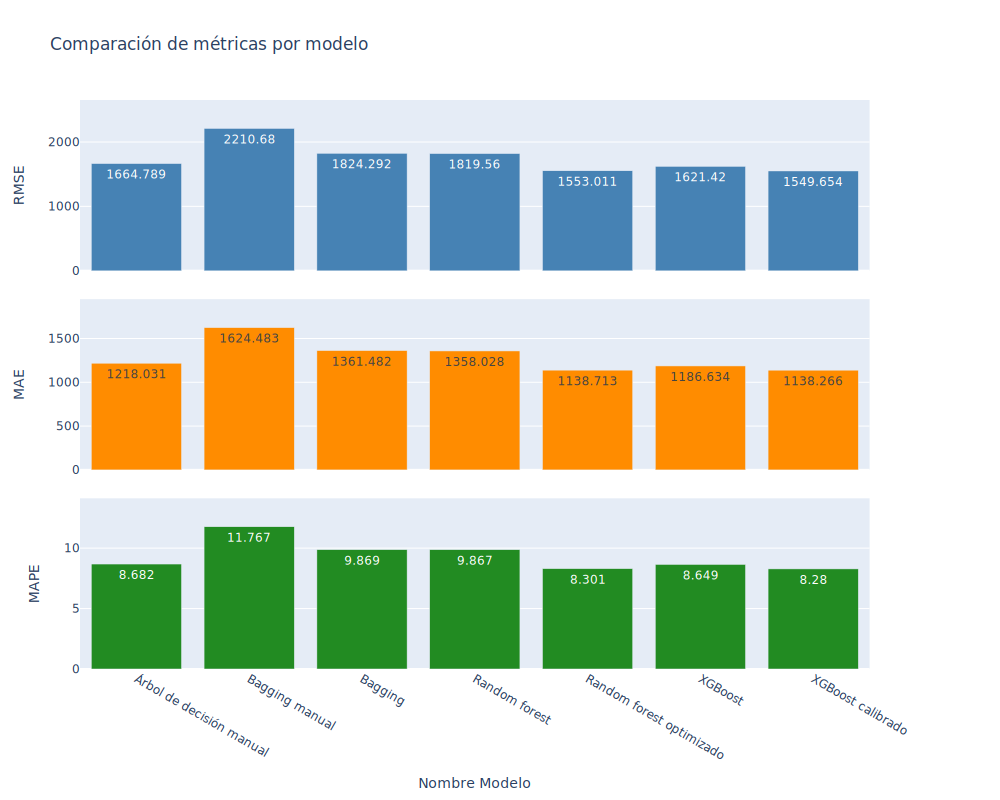

In [33]:
# Celda 8
metrics_df = pd.DataFrame(metrics_models)
metrics_cols = metrics_df.columns[1:4]
colors_cols = {
    'RMSE': 'steelblue',
    'MAE': 'darkorange',
    'MAPE': 'forestgreen' 
}

fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                       specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}]])

for i in range(len(metrics_cols)):
    col = metrics_cols[i]
    color = colors_cols[col]
    
    fig.add_trace(go.Bar(
        x=metrics_df['Nombre Modelo'],
        y=metrics_df[col],
        name=col,
        marker_color=color,
        text=metrics_df[col],
        textposition='auto'
    ), row=i+1, col=1, secondary_y=False)

    fig.update_yaxes(title_text=col, secondary_y=False, row=i+1, col=1, range=[0, metrics_df[col].max() * 1.2])

fig.update_xaxes(title_text='Nombre Modelo', row=3, col=1)
fig.update_layout(
    title='Comparación de métricas por modelo',
    height=800,
    width=1000,
    showlegend=False
)

fig.show()
